In [3]:
%matplotlib inline
import PyGreentea as pygt
import network_generator
from network_generator import NetConf, UNetConf
import greentea_client as gtc
import math
import pandas as pd

In [4]:
# class NetConf(object):
#     def __init__(self, 
#                  num_u=1, 
#                  input_width=132, 
#                  output_width=44,
#                  memory_limit_global_gb=10, 
#                  memory_limit_buffer_gb=4
#                 ):
#         # 10 GB total memory limit
#         self.mem_global_limit = memory_limit_global_gb * 1024 * 1024 * 1024
#         # 4 GB single buffer memory limit
#         self.mem_buf_limit = memory_limit_buffer_gb * 1024 * 1024 * 1024
#         # Network input dimension
#         self.input_shape = [input_width, input_width, input_width]
#         # Corresponding output dimension
#         self.output_shape = [output_width, output_width, output_width]
#         # Number of feature maps in the start
#         self.fmap_start = 16
#         # Number of input feature maps
#         self.fmap_input = 1
#         # Number of ouput feature maps
#         self.fmap_output = 3
#         # Loss function and mode ("malis", "euclid", "softmax")
#         self.loss_function = "euclid"
#         # ReLU negative slope
#         self.relu_slope = 0.005
#         # Batch normalization
#         self.use_batchnorm = True
#         # Batch normalization moving average fraction
#         self.batchnorm_maf = 0.95
#         # Dropout
#         self.dropout = 0.2
#         # Ignore convolution buffer in memory computations
#         self.ignore_conv_buffer = False
#         # U-Net configurations
#         self.u_netconfs = [UNetConf() for _ in range(num_u)]

In [5]:
# netconf = NetConf(num_u=2, memory_limit_buffer_gb=4, memory_limit_global_gb=4)
netconf = NetConf()
netconf.ignore_conv_buffer = True  # for cuDNN
netconf.use_batchnorm = False
netconf.dropout = 0.0
print(netconf.u_netconfs)

[<network_generator.UNetConf instance at 0x7f780dbf9cf8>]


In [30]:
num_u_nets = 1
n_levels = 4
n_convs_down = 2
n_convs_up = 2
feature_maps_start = 1
feature_maps_multiplier = 3

###
netconf.u_netconfs = []
netconf.fmap_start = feature_maps_start
# first U Net
u_net = UNetConf()
u_net.unet_depth = n_levels
u_net.unet_conv_down = [[[3]]*n_convs_down]
u_net.unet_conv_up = [[[3]]*n_convs_up]
netconf.u_netconfs.append(u_net)
# second U Net
# u_net = UNetConf()
# u_net.unet_depth = 2
# u_net.unet_conv_down = [[[3]]*1]
# u_net.unet_conv_up = [[[3]]*1]
# netconf.u_netconfs.append(u_net)
for u_net_conf in netconf.u_netconfs:
    u_net_conf.unet_downsampling_strategy = [[2]]*u_net_conf.unet_depth
    u_net_conf.unet_fmap_inc_rule = lambda fmaps: \
        int(math.ceil(fmaps * feature_maps_multiplier))
    u_net_conf.unet_fmap_dec_rule = lambda fmaps: \
        int(math.ceil(fmaps / feature_maps_multiplier))

print(netconf.u_netconfs)


[<network_generator.UNetConf instance at 0x7f782d431518>]


In [31]:
# We test memory usage for training
mode = pygt.netgen.caffe_pb2.TRAIN
# The minimum we're interested in
shape_min = [1,1,1]
# shape_min = [130,130,130]
# And maximum
# shape_max = [150,150,150]
shape_max = [1000, 1000, 1000]
# We want Z and Y to be independent, but X == Y
constraints = [None, lambda x: x[0], lambda x: x[0]]
# constraints = [None]*3
# Compute (can be quite intensive)
inshape, outshape, fmaps = pygt.netgen.compute_valid_io_shapes(
    netconf,
    mode,
    shape_min,
    shape_max,
    constraints=constraints
)

-- Invalid: [1] => []
-- Invalid: [2] => []
-- Invalid: [3] => []
-- Invalid: [4] => []
-- Invalid: [5] => []
-- Invalid: [6] => []
-- Invalid: [7] => []
-- Invalid: [8] => []
-- Invalid: [9] => []
-- Invalid: [10] => []
-- Invalid: [11] => []
-- Invalid: [12] => []
-- Invalid: [13] => []
-- Invalid: [14] => []
-- Invalid: [15] => []
-- Invalid: [16] => []
-- Invalid: [17] => []
-- Invalid: [18] => []
-- Invalid: [19] => []
-- Invalid: [20] => []
-- Invalid: [21] => []
-- Invalid: [22] => []
-- Invalid: [23] => []
-- Invalid: [24] => []
-- Invalid: [25] => []
-- Invalid: [26] => []
-- Invalid: [27] => []
-- Invalid: [28] => []
-- Invalid: [29] => []
-- Invalid: [30] => []
-- Invalid: [31] => []
-- Invalid: [32] => []
-- Invalid: [33] => []
-- Invalid: [34] => []
-- Invalid: [35] => []
-- Invalid: [36] => []
-- Invalid: [37] => []
-- Invalid: [38] => []
-- Invalid: [39] => []
-- Invalid: [40] => []
-- Invalid: [41] => []
-- Invalid: [42] => []
-- Invalid: [43] => []
-- Invalid: [44] => 

In [32]:
for i, o in enumerate(zip(inshape,outshape,fmaps)):
#     print('i=' + str(i))
    print('{n_levels}\t{n_convs_down}\t{n_convs_up}\t'
          '{input_width}\t{output_width}\t{feature_maps}'
          .format(n_levels=n_levels,
                  n_convs_down=n_convs_down,
                  n_convs_up=n_convs_up,
                  input_width=o[0][0], 
                  output_width=o[1][0],
                  feature_maps=fmaps[i],
                 )
         )
#     print(o)

4	2	2	188	4	48
4	2	2	204	20	40
4	2	2	220	36	34
4	2	2	236	52	27
4	2	2	252	68	22
4	2	2	268	84	18
4	2	2	284	100	14
4	2	2	300	116	11
4	2	2	316	132	9
4	2	2	332	148	7
4	2	2	348	164	6
4	2	2	364	180	5
4	2	2	380	196	4
4	2	2	396	212	3
4	2	2	412	228	3
4	2	2	428	244	2
4	2	2	444	260	2
4	2	2	460	276	2
4	2	2	476	292	1
4	2	2	492	308	1
4	2	2	508	324	1
4	2	2	524	340	1
4	2	2	540	356	1


   Combined input size  Combined output size  Feature maps
0              2000376                    64           118
1              2863288                  8000           108
2              3944312                 46656            94
3              5268024                140608            78
4              6859000                314432            62


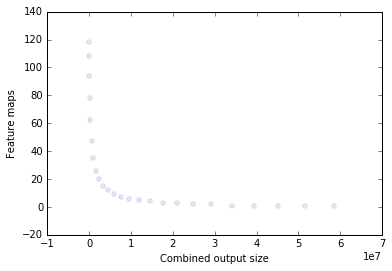

In [29]:
import pandas as pd
df = pd.DataFrame({
        'Combined input size': [x[0]*x[1]*x[2] for x in inshape],
        'Combined output size': [x[0]*x[1]*x[2] for x in outshape],
        'Feature maps': fmaps
    })
print(df.head())
ax = df.plot(
    kind='scatter',
    x='Combined output size',
    y='Feature maps',
#     logx=True,
#     s=1
    alpha=0.1
)

In [34]:
i=4
netconf.input_shape = inshape[i]
netconf.output_shape = outshape[i]
netconf.fmap_start = fmaps[i]
# netconf.input_shape = 124
# netconf.output_shape = 44
# netconf.fmap_start = 10

print ('netconf.input_shape = %s' % netconf.input_shape)
print ('netconf.output_shape = %s' % netconf.output_shape)
print ('netconf.fmap_start = %s' % netconf.fmap_start)

netconf.loss_function = "euclid"
train_net_conf_euclid, test_net_conf = pygt.netgen.create_nets(netconf)
netconf.loss_function = "malis"
train_net_conf_malis, test_net_conf = pygt.netgen.create_nets(netconf)

netconf.input_shape = [132, 132, 132]
netconf.output_shape = [38, 38, 38]
netconf.fmap_start = 112
Shape: [0]
f: 1 w: [132, 132, 132] d: [1, 1, 1]
WM: 0
CM: 0
AM: 0
Shape: [1]
f: 112 w: [130, 130, 130] d: [1, 1, 1]
WM: 12096
CM: 248396544
AM: 0
Shape: [2]
f: 112 w: [128, 128, 128] d: [1, 1, 1]
WM: 1354752
CM: 26574912000
AM: 0
Shape: [3]
f: 112 w: [64, 64, 64] d: [1, 1, 1]
WM: 0
CM: 0
AM: 0
Shape: [4]
f: 336 w: [62, 62, 62] d: [1, 1, 1]
WM: 4064256
CM: 3170893824
AM: 0
Shape: [5]
f: 336 w: [60, 60, 60] d: [1, 1, 1]
WM: 12192768
CM: 8648446464
AM: 0
Shape: [6]
f: 336 w: [30, 30, 30] d: [1, 1, 1]
WM: 0
CM: 0
AM: 0
Shape: [7]
f: 1008 w: [28, 28, 28] d: [1, 1, 1]
WM: 36578304
CM: 979776000
AM: 0
Shape: [8]
f: 1008 w: [26, 26, 26] d: [1, 1, 1]
WM: 109734912
CM: 2389782528
AM: 0
Shape: [9]
f: 1008 w: [13, 13, 13] d: [1, 1, 1]
WM: 0
CM: 0
AM: 0
Shape: [10]
f: 3024 w: [11, 11, 11] d: [1, 1, 1]
WM: 329204736
CM: 239174208
AM: 0
Shape: [11]
f: 3024 w: [9, 9, 9] d: [1, 1, 1]
WM: 987614208
CM: 434

In [178]:
print(str(train_net_conf_euclid))

layer {
  name: "data"
  type: "MemoryData"
  top: "data"
  top: "datai"
  memory_data_param {
    dim: 1
    dim: 1
    dim: 220
    dim: 220
    dim: 220
  }
}
layer {
  name: "label"
  type: "MemoryData"
  top: "label"
  top: "labeli"
  memory_data_param {
    dim: 1
    dim: 3
    dim: 44
    dim: 44
    dim: 44
  }
}
layer {
  name: "scale"
  type: "MemoryData"
  top: "scale"
  top: "scalei"
  memory_data_param {
    dim: 1
    dim: 3
    dim: 44
    dim: 44
    dim: 44
  }
}
layer {
  name: "silence"
  type: "Silence"
  bottom: "datai"
  bottom: "labeli"
  bottom: "scalei"
}
layer {
  name: "Convolution1"
  type: "Convolution"
  bottom: "data"
  top: "Convolution1"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  convolution_param {
    num_output: 5
    pad: 0
    kernel_size: 3
    group: 1
    stride: 1
    weight_filler {
      type: "gaussian"
      std: 0.272165526976
    }
    bias_filler {
      type: "constant"
    }
    dilation: 1
    dilation: 1
    dilatio

In [177]:
with open('net_train_euclid.prototxt', 'w') as f:
#     print(train_net_conf_euclid, file=f)
    f.write(str(train_net_conf_euclid))
with open('net_train_malis.prototxt', 'w') as f:
#     print(train_net_conf_malis, file=f)
    f.write(str(train_net_conf_malis))
with open('net_test.prototxt', 'w') as f:
#     print(test_net_conf, file=f)
    f.write(str(test_net_conf))
